# Proyecto NLP

In [17]:
! pip install wordcloud unidecode nltk

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.1.2 -> 23.3.1
[notice] To update, run: pip install --upgrade pip


In [47]:
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import re
from unidecode import unidecode
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import numpy as np
from tqdm import tqdm
tqdm.pandas()
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
import regex as re
from nltk import download
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV


In [19]:
# Cargarmos el archivo separado por tabulador (antes eliminar una fila vacía)
df = pd.read_csv('https://raw.githubusercontent.com/4GeeksAcademy/NLP-project-tutorial/main/url_spam.csv')
df.head()

,url,is_spam
0,https://briefingday.us8.list-manage.com/unsubs...,True
1,https://www.hvper.com/,True
2,https://briefingday.com/m/v4n3i4f3,True
3,https://briefingday.com/n/20200618/m#commentform,False
4,https://briefingday.com/fan,True


In [20]:
df.shape

(2999, 2)

# Paso 2 : comprobación de posibles páginas web duplicadas


In [21]:
df["is_spam"] = df["is_spam"].apply(lambda x: 1 if x else 0).astype(int)
df.head()

,url,is_spam
0,https://briefingday.us8.list-manage.com/unsubs...,1
1,https://www.hvper.com/,1
2,https://briefingday.com/m/v4n3i4f3,1
3,https://briefingday.com/n/20200618/m#commentform,0
4,https://briefingday.com/fan,1


In [22]:
print(df.shape)


(2999, 2)


In [23]:
# Comprobación de posibles tweets duplicados
print(f'Número de tweets duplicados: {df.duplicated().sum()}')

Número de tweets duplicados: 630


In [24]:
for col in df.columns:
    if df[col].apply(lambda x: isinstance(x, list)).any():
        df[col] = df[col].astype(str)
df_sin_duplicados = df.drop_duplicates()


In [25]:
df_sin_duplicados.shape

(2369, 2)

In [26]:
# Comprobación de valores faltantes
df['url'].isna().sum()

0

In [27]:
# Comporbamos que ahora nuestro dataset esté balanceado
df.is_spam.value_counts()

is_spam
0    2303
1     696
Name: count, dtype: int64

In [28]:
def preprocess_text(text):
    # Eliminar cualquier carácter que no sea una letra (a-z) o un espacio en blanco ( )
    text = re.sub(r'[^a-z ]', " ", text)
    
    # Eliminar espacios en blanco
    text = re.sub(r'\s+[a-zA-Z]\s+', " ", text)
    text = re.sub(r'\^[a-zA-Z]\s+', " ", text)

    # Múltiples espacios en blanco en uno
    text = re.sub(r'\s+', " ", text.lower())

    # Eliminar etiquetas
    text = re.sub("&lt;/?.*?&gt;"," &lt;&gt; ", text)

    return text.split()

df_sin_duplicados["url"] = df_sin_duplicados["url"].apply(preprocess_text)
df_sin_duplicados.head()

/tmp/ipykernel_469/48672726.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sin_duplicados["url"] = df_sin_duplicados["url"].apply(preprocess_text)


,url,is_spam
0,"[https, briefingday, us, list, manage, com, un...",1
1,"[https, www, hvper, com]",1
2,"[https, briefingday, com, v, i]",1
3,"[https, briefingday, com, m, commentform]",0
4,"[https, briefingday, com, fan]",1


In [29]:
# Se hace la lematización, la eliminación de Palabras Vacías (Stop Words) y Filtrado por Longitud de Palabra no menos que 3
download("wordnet")
lemmatizer = WordNetLemmatizer()

download("stopwords")
stop_words = stopwords.words("english")

def lemmatize_text(words, lemmatizer = lemmatizer):
    tokens = [lemmatizer.lemmatize(word) for word in words]
    tokens = [word for word in tokens if word not in stop_words]
    tokens = [word for word in tokens if len(word) > 3]
    return tokens

df_sin_duplicados["url"] = df_sin_duplicados["url"].apply(lemmatize_text)
df_sin_duplicados.head()

[nltk_data] Downloading package wordnet to /home/vscode/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /home/vscode/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
/tmp/ipykernel_469/1031046062.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sin_duplicados["url"] = df_sin_duplicados["url"].apply(lemmatize_text)


,url,is_spam
0,"[http, briefingday, list, manage, unsubscribe]",1
1,"[http, hvper]",1
2,"[http, briefingday]",1
3,"[http, briefingday, commentform]",0
4,"[http, briefingday]",1


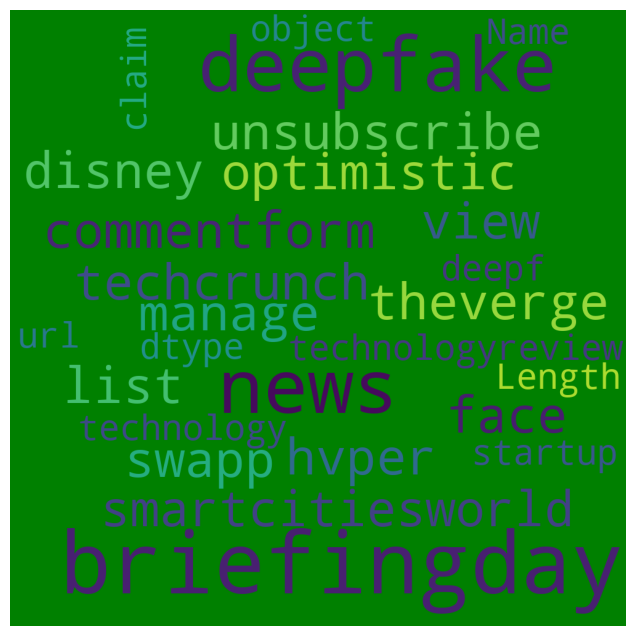

In [40]:
wordcloud = WordCloud(width = 1000, height = 1000, background_color = "green", max_words = 2000, min_font_size = 20, random_state = 42)\
    .generate(str(df_sin_duplicados["url"]))

fig = plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

COMO SE OBSERVA EN LA NUBE DE PALABRAS DEEPTAKE, BRIEFINGDAY Y NEWS SON LAS PALABRAS QUE MAS SE REPITEN 

In [41]:
tokens_list = df_sin_duplicados["url"]
tokens_list = [" ".join(tokens) for tokens in tokens_list]

vectorizer = TfidfVectorizer(max_features = 5000, max_df = 0.8, min_df = 5)
X = vectorizer.fit_transform(tokens_list).toarray()
y = df_sin_duplicados["is_spam"]

X[:5]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

# Paso 3: construir una SVM


In [43]:
model = SVC(kernel = "linear", random_state = 42)
model.fit(X_train, y_train)

SVC(kernel='linear', random_state=42)

In [44]:
y_pred = model.predict(X_test)
y_pred

array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,

In [45]:
accuracy_score(y_test, y_pred)

0.9514767932489452

LUEGO DE VER LA PREDICCION EN EL ANTERIOR ARRAY SE PUEDE OBSERVAR QUE EN DONDE ES 0 EL MENSAJE NO HA SIDO SPAM Y 1 EL CONTRARIO. ADEMAS SE OBSERVA QUE EL MODELO ESTA ACERTANDO EL 95% DE LAS VECES.


# Paso 4: optimizar el modelo anterior


In [48]:
hyperparams = {
    "C": [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    "kernel": ["linear", "poly", "rbf", "sigmoid", "precomputed’"],
    "degree": [1, 2, 3, 4, 5],
    "gamma": ["scale", "auto"]
}

# Inicializamos la búsqueda aleatoria
grid = GridSearchCV(model, hyperparams, scoring = "accuracy", cv = 5)
grid

GridSearchCV(cv=5, estimator=SVC(kernel='linear', random_state=42),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                         'degree': [1, 2, 3, 4, 5], 'gamma': ['scale', 'auto'],
                         'kernel': ['linear', 'poly', 'rbf', 'sigmoid',
                                    'precomputed’']},
             scoring='accuracy')

In [49]:
grid.fit(X_train, y_train)

print(f"Best hyperparameters: {grid.best_params_}")

Best hyperparameters: {'C': 1000, 'degree': 1, 'gamma': 'auto', 'kernel': 'poly'}


/home/vscode/.local/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
350 fits failed out of a total of 1750.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
350 fits failed with the following error:
Traceback (most recent call last):
  File "/home/vscode/.local/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/vscode/.local/lib/python3.11/site-packages/sklearn/base.py", line 1145, in wrapper
    estimator._validate_params()
  File "/home/vscode/.local/lib/python3.11/site-packages/sklearn/base.py", line 638, in _validate_params
    validate_parameter_constraints(
  File "/home/vscode/.l

In [50]:
modelo_optimizado = SVC(C = 1000, degree = 1, gamma = "auto", kernel = "poly", random_state = 42)
modelo_optimizado.fit(X_train, y_train)
y_pred = modelo_optimizado.predict(X_test)
accuracy_score(y_test, y_pred)

0.9620253164556962

AL OBTENER LOS MEJORES HIPERPARAMETROS Y AJUSTARLOS AL MODELO EL MODELO HA SUBIDO SU PRECISION AL 96%.

In [ ]:
from pickle import dump

dump(model, open("/workspaces/Proyecto-de-NLP/models.sav", "wb"))